In [212]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [214]:
sns.set(rc={'figure.figsize': (9,6)})

In [215]:
events_data = pd.read_csv('/home/kex/Documents/stepic/datascience/event_data_train.csv')
submissions_data = pd.read_csv('/home/kex/Documents/stepic/datascience/submissions_data_train.csv')

In [223]:
events_data.head(10)

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15
5,32811,1434340895,passed,17632,2015-06-15 04:01:35,2015-06-15
6,32929,1434340921,discovered,17632,2015-06-15 04:02:01,2015-06-15
7,32929,1434340921,viewed,17632,2015-06-15 04:02:01,2015-06-15
8,32929,1434340939,started_attempt,17632,2015-06-15 04:02:19,2015-06-15
9,32929,1434340944,passed,17632,2015-06-15 04:02:24,2015-06-15


In [222]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit = 's')
events_data['day'] = events_data.date.dt.date
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit = 's')
submissions_data['day'] = submissions_data.date.dt.date

In [324]:
users_events_data = events_data.pivot_table(index='user_id',
                            columns='action',
                            values='step_id',
                            aggfunc='count',
                            fill_value=0).reset_index()

In [325]:
users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [230]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [236]:
users_scores = submissions_data.pivot_table(index='user_id',
                            columns='submission_status',
                            values='step_id',
                            aggfunc='count',
                            fill_value=0).reset_index().head()

In [299]:
submissions_data.pivot_table(index='user_id',
                            columns='submission_status',
                            values='step_id',
                            aggfunc='count',
                            fill_value=0).reset_index().head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [244]:
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values

In [246]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))

In [249]:
gap_data = gap_data / (24*3600)

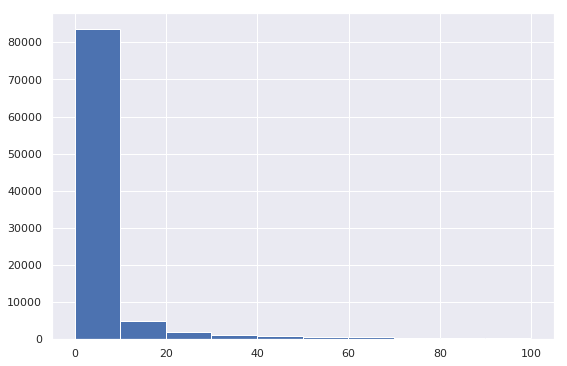

In [252]:
gap_data[gap_data < 100].hist()

In [254]:
gap_data.quantile(0.95)

59.760440972222156

In [304]:
users_data = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_timestamp'})

In [309]:
events_data.tail()

,step_id,timestamp,action,user_id,date,day
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


In [315]:
now = 1526772811
drop_out_treshold = 30*24*3600
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_treshold

In [320]:
users_data = users_data.merge(users_scores, how ='outer')

In [322]:
users_data = users_data.fillna(0)

In [323]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0


In [326]:
users_data = users_data.merge(users_events_data, how ='outer')

In [332]:
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()

In [334]:
users_data = users_data.merge(users_days, how ='outer')

In [338]:
users_data['passed_course'] = users_data.passed > 170

In [339]:
users_data.head(10)

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False
5,8,1481466913,True,9.0,21.0,109,84,37,156,2,False
6,9,1484999497,True,0.0,0.0,3,3,0,4,1,False
7,11,1526140625,False,0.0,0.0,1,0,1,1,1,False
8,14,1436368676,True,0.0,1.0,4,3,1,9,1,False
9,16,1513162585,True,0.0,0.0,196,196,108,651,21,True


In [336]:
users_data.user_id.nunique()

19234

In [337]:
events_data.user_id.nunique()

19234

In [341]:
users_data.groupby('passed_course').count()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_course,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425
